## 최종 Flow 만들어 가는 중....

- 구성 노드 : Vector DB / Neo4j DB / Slack
- 노드 선택 여부 : GPT Function Calling
- 검색을 위한 질문 재생성 : DeepRetrieval-PubMed-3B
- 검색 문서 평가 : LLM as a Judge

In [ ]:
from typing import Annotated, List, TypedDict, Dict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI
from transformers import AutoTokenizer, AutoModelForCausalLM
import os

load_dotenv()
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 사용 모델들
model_client = OpenAI()
model = ChatOpenAI(temperature=0.2,
                    model_name="gpt-4o")
# tokenizer = AutoTokenizer.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model = AutoModelForCausalLM.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model.to(device)

# langgraph state 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]  
    decision_slack: Annotated[str, "Decision_slack"]
    tools: Annotated[List, "Tools"]
    tools_query: Annotated[List, "Tools_Query"]
    # regenerated_question: Annotated[str, "Regenerated Question"]
    neo4j_documents: Annotated[List, "Neo4j_Documents"]  
    vector_documents : Annotated[List,"Vector_Documents"]
    final_answer: Annotated[str, "Final_Answer"]  
    slack_response: Annotated[str, "Slack_Response"]
    messages: Annotated[List, add_messages] 

memory = MemorySaver()

# MCP 서버들 불러오기
mcp_client = MultiServerMCPClient(
    {
        "neo4j_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_vectordb_server.py"],
            "transport": "stdio",
        },
        # Slack MCP 서버 설정
        "slack": {
            "command": "npx",
            "args": [
                "-y",
                "@modelcontextprotocol/server-slack"
            ],
            "transport": "stdio", 
            "env": {
                "SLACK_BOT_TOKEN": os.getenv("SLACK_BOT_TOKEN"),
                "SLACK_TEAM_ID": os.getenv("SLACK_TEAM_ID"),
                # 선택사항: 특정 채널만 접근하려는 경우
                # "SLACK_CHANNEL_IDS": 
            }
        }
    }
)

# MCP 서버 잘 가져왔는지 확인
mcp_tools = await mcp_client.get_tools()
tools_dict = {tool.name: tool for tool in mcp_tools}
print(tools_dict)

{'neo4j_retriever': StructuredTool(name='neo4j_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'neo4j_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x17338e200>), 'VectorDB_retriever': StructuredTool(name='VectorDB_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'VectorDB_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x1733e32e0>), 'slack_list_channels': StructuredTool(name='slack_list_channels', description='List public or pre-defined channels in the workspace with pagination', args_schema={'type': 'object', 'properties': {'limit': {'type': 'number', 'description': 'Maximum number of channels to return (default 100, max 200)'

In [ ]:
# from langchain_mcp_adapters.client import MultiServerMCPClient
# from langgraph.prebuilt import create_react_agent

# mcp_client = MultiServerMCPClient(
#     {
#         # 올바른 Slack MCP 서버 설정
#         "slack": {
#             "command": "npx",
#             "args": [
#                 "-y",
#                 "@modelcontextprotocol/server-slack"
#             ],
#             "transport": "stdio",  # transport 추가 필요
#             "env": {
#                 "SLACK_BOT_TOKEN": 
#                 "SLACK_TEAM_ID": 
#                 # 선택사항: 특정 채널만 접근하려는 경우
#                 # "SLACK_CHANNEL_IDS": 
#             }
#         }
#     }
# )


# tools = await mcp_client.get_tools()

# # OpenAI 모델 설정
# model_client = OpenAI()

# model = ChatOpenAI(temperature=0.2,
#                       model_name="gpt-4o")

# # 에이전트 생성
# agent = create_react_agent(model, tools)

# # 에이전트에게 자연어로 지시 -> 채널명 지정 필요
# response = await agent.ainvoke({
#     "messages": [{
#         "role": "user",
#         "content": (
#             "백지연의 다이렉트 메시"
#             "slack_post_message 툴을 사용해."
#         )
#     }]
# })
# print(response)

In [3]:
function_calling_tools = [
    {
        "type": "function",
        "name": "neo4j_retriever",
        "description": """Use this tool when the user's query is explicitly about patient-specific 
            clinical information or refers to structured medical records.

            This includes queries containing terms such as: 
            '환자', '환자정보', '환자기록', '환자이력', '환자데이터', '환자상태', 
            '수술이력', '검사기록', '진료기록', '입원', '퇴원', '복용약물',
            '진단', '수술명', '마취제', '마취제 유형', '수술 전 상태', '수술 후 상태'.

            These queries typically require retrieving structured data from graph-based 
            medical records (e.g., Neo4j) related to an individual patient or to specific 
            clinical procedures.

            This tool is designed to access and return relevant information such as:
            surgery history, diagnoses, anesthesia types used, pre- and post-operative conditions, 
            medication usage, lab results, and hospitalization records.

            Use this tool when the question involves:
            - Specific patients
            - Specific treatments or surgeries
            - Named diagnoses or procedures
            - Clinical state before/after operations

            Do not use this tool for general medical knowledge, non-clinical topics, or 
            queries unrelated to structured or relational patient data.""",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": """Please write the query as a natural language question about the patient's clinical records.

                    The query will be interpreted to explore nodes (e.g., Surgery, Anesthesia, Diagnosis, Patient) and their relationships (e.g., surgeries received by a specific patient) in a graph database.

                    For example, the question "Tell me the name of the most recent surgery and the anesthesia used" will be processed as a query exploring connections between Surgery and Anesthesia nodes.

                    Also, the question "Tell me the pre-operative condition and diagnosis of patient Hong Gil-dong" will be interpreted as a query that finds the Person node with the name 'Hong Gil-dong' and extracts the related Pre-op condition and Diagnosis nodes.

                    If a patient name is specified, please write the query to retrieve not only that patient but also other patients with similar symptoms.

                    If no patient name is given, please write the query to search for patients matching the symptoms, surgery names, or diagnoses mentioned in the question.

                    The more specific the patient information or clinical conditions included, the more accurately the relevant data can be retrieved."""
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    },
    {
        "type": "function",
        "name": "VectorDB_retriever",
        "description": """BrokenPipeErrorUse this tool when the user's query involves general clinical or medical knowledge that is not tied to a specific patient.

                This includes queries containing medical or procedural terms such as:
                surgery names (e.g., "cholecystectomy", "cardiac surgery"), anesthesia types (e.g., "general anesthesia", "local anesthesia"), medications, clinical processes, or treatment guidelines.

                Example queries:
                - "How does general anesthesia work?"
                - "What are common complications of this surgery?"
                - "What anesthetics are typically used in pediatric patients?"

                These types of queries are interpreted as requests for background medical knowledge or conceptual explanations. The tool retrieves semantically relevant information from a vector-based medical knowledge database.

                Do not use this tool for patient-specific record queries or when structured relational data is needed, such as diagnosis timelines or surgical histories.""",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": """Construct a query that focuses on general medical or clinical knowledge, excluding any patient-specific details.

                The query should be based on concepts extracted from the user's original question, such as surgery names, anesthesia types, diagnoses, medications, or treatment processes.

                For example, if the user asks "What kind of anesthesia was used for Kim's surgery?", the query should be reformulated as "What types of anesthesia are commonly used for that kind of surgery?"

                Avoid including patient names, identifiers, or individual medical histories. Focus on retrieving background information or typical medical explanations that are generally applicable."""
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    }
]

In [4]:
LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
사용자의 질문에 대해 다음 두 가지 출처의 정보를 참고하여 답변을 생성하세요:

1. 🔎 Neo4j 검색 결과: 구조화된 환자 관련 정보 (예: 수술 이력, 검사 기록 등)
2. 📚 VectorDB 검색 결과: 일반적인 의학 지식 (예: 증상 설명, 치료 가이드라인 등)

- 두 결과 모두 존재할 경우, 각 출처를 구분하여 통합적으로 반영하되, 중복 내용은 요약하거나 통합하세요.
- 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하되, 정보의 한계에 대해 언급하지 말고 최대한 성실히 답변하세요.
- 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
- 불필요한 서론 없이, 질문에 바로 답변하세요.

# Neo4j CONTEXT
{Neo4j}

# Vector DB CONTEXT
{VectorDB}

# Question
{question}
"""


# LLM_REGENERATED_QUESTION = """
# You are a helpful assistant specialized in pediatric anesthesia. 
# You first think about the reasoning process in your mind and then rewrite the user’s question into a more effective form for document retrieval. 
# Your task is to convert user questions into concise, keyword-based queries suitable for sparse vector-based search in a pediatric anesthesia knowledge base.

# Show your thought process in <think> </think> tags.  
# Your final response must be in JSON format within <answer> </answer> tags.  
# For example:  
# <answer>  
# {{  
#   "query": "..."  
# }}  
# </answer>

# Note: You may use Boolean operators (AND, OR) and parentheses when needed to group terms.

# Here’s the user’s question related to pediatric anesthesia:  
# {question}

# Assistant: Let me think step by step.  
# <think>
# """

LLM_DECISION_SLACK = """
You are a decision-making assistant for Slack dispatch.
If the user asks to send a message or question to a specific person via Slack (e.g., '~에게 보내줘', '~에게 전송해줘'),
respond with "Yes".
Otherwise, respond with "No".

Only respond with "Yes" or "No". Do not include any explanation or formatting.
"""

In [ ]:
# import json

# question = "A환자 정보와 감기에 대해서 알려줘"

# input_messages = [
#     {"role": "system", "content": "Decide which tools to use to answer the user's question. You may call one or both."},
#     {"role": "user", "content": question}
# ]

# response = model_client.responses.create(model="gpt-4.1",
#                                             input=input_messages,
#                                             tools=tools)
# print(response.output)

[ResponseFunctionToolCall(arguments='{"query":"A환자 정보 알려줘"}', call_id='call_bYFRVMgTLp5Zsn4IvBqKKgam', name='neo4j_retriever', type='function_call', id='fc_68602cba820081a299158122efc8e342043d4b3d165b18d0', status='completed'), ResponseFunctionToolCall(arguments='{"query":"감기에 대해 알려줘"}', call_id='call_9HTmUVu93LJdBYryHvo5fjdU', name='VectorDB_retriever', type='function_call', id='fc_68602cba9d3881a29cd165a36bf0e5e9043d4b3d165b18d0', status='completed')]


In [ ]:
# question = "Kasabach-Merrritt Syndrome이 뭐야?"

# input_text = LLM_REGENERATED_QUESTION.format(question = question)
# inputs = tokenizer(input_text, return_tensors="pt").to(device)
# outputs = deepretrieval_model.generate(**inputs, 
#                             max_new_tokens=100,
#                             temperature = 0.6)
# response = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print(response)

KeyboardInterrupt: 

In [ ]:
# from langchain.chat_models import ChatOpenAI
# import re

# model = ChatOpenAI(temperature=0.2, model_name="gpt-4o")

# LLM_DECISION_SLACK = """
# You are a decision-making assistant for Slack dispatch.
# If the user asks to send a message or question to a specific person via Slack (e.g., '~에게 보내줘', '~에게 전송해줘'),
# respond with "yes".
# Otherwise, respond with "no".

# Only respond with "yes" or "no". Do not include any explanation or formatting.
# """

# SEND_COMMANDS = ["보내줘", "전송해줘"]

# def determine_slack_usage(query: str) -> str:
#     pattern = re.compile(r"(.+?)에게\s*(.+?)\s*(?:Slack으로\s*)?(보내줘|전송해줘)")
#     m = pattern.search(query)
#     return 'Yes' if m else 'No'

# def decision_tools(question: str):
#     user_query = question

#     # 1) Rule-based 판단
#     use_slack = determine_slack_usage(user_query)
#     response = use_slack

#     # 2) 명확하지 않은 경우 → LLM 판단
#     if use_slack == 'No' and ("에게" in user_query or any(cmd in user_query for cmd in SEND_COMMANDS)):
#         llm_response = model.invoke(f"{LLM_DECISION_SLACK}\n\n{user_query}")
        
#         response = llm_response
#     print(response)
#     return response

# # 테스트
# decision_tools(question="윤왕규 간호사한테 'hi' 메세지 전달해줘")

No


'No'

In [5]:
import json
import re
from langgraph.prebuilt import create_react_agent

SEND_COMMANDS = ["보내줘", "전송해줘", "전달해줘"]

# def determine_slack_usage(query: str) -> str:
#     command_pattern = "|".join(SEND_COMMANDS)  
#     pattern = re.compile(rf"(.+?)에게\s*(.+?)\s*(?:Slack으로\s*)?({command_pattern})")
#     m = pattern.search(query)
#     return 'Yes' if m else 'No'

def determine_slack_usage(query: str) -> str:
    return 'Yes' if any(cmd in query for cmd in SEND_COMMANDS) else 'No'

async def decision_slack(state: ChatbotState):
    user_query = state["question"]

    # 1) Rule-based 판단
    use_slack = determine_slack_usage(user_query)
    response = use_slack  # 기본값 설정

    # 2) 패턴은 일부 있지만 명확하지 않은 경우 → LLM 판단
    if use_slack.lower() == 'no' and ("에게" in user_query or any(cmd in user_query for cmd in SEND_COMMANDS)):
        llm_response = await model.ainvoke(f"{LLM_DECISION_SLACK}\n\n{user_query}")
        response = llm_response

    return ChatbotState(decision_slack=response)

async def decision_tools(state: ChatbotState):
    
    question = state["question"]

    input_messages = [
        {"role": "system", "content": "Decide which tools to use to answer the user's question. You may call one or both."},
        {"role": "user", "content": question}
    ]
    
    response = model_client.responses.create(model="gpt-4.1",
                                             input=input_messages,
                                             tools=function_calling_tools)
    
    tools_name = [tool.name for tool in response.output]
    tools_query = [json.loads(call.arguments)["query"] for call in response.output]

    return ChatbotState(tools=tools_name,
                        tools_query=tools_query)

async def vector_db(state: ChatbotState):
    question = None
    for tool, q in zip(state["tools"], state["tools_query"]):
        if tool == "VectorDB_retriever":
            question = q
            break

    # 질문 재생성
    # input_text = LLM_REGENERATED_QUESTION.format(question = question)
    # inputs = tokenizer(input_text, return_tensors="pt")
    # outputs = model.generate(**inputs, 
    #                          max_new_tokens=500,
    #                          temperature = 0.6)
    # response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
    vectordb_tool = tools_dict["VectorDB_retriever"]
        
    result = await vectordb_tool.ainvoke({"query": question})

    return ChatbotState(vector_documents=result,
                        # regenerated_question=response
                        )

async def neo4j_db(state: ChatbotState):
    question = None
    for tool, q in zip(state["tools"], state["tools_query"]):
        if tool == "neo4j_retriever":
            question = q
            break
    
    neo4j_tool = tools_dict.get("neo4j_retriever")
    
    result = await neo4j_tool.ainvoke({"query": question})

    return ChatbotState(neo4j_documents=result)

async def merge_outputs(state:ChatbotState):

    question = state['question']
    vector_documents = state['vector_documents']
    neo4j_documents = state['neo4j_documents']

    slack_state = state['decision_slack']

    formatted = LLM_SYSTEM_PROMPTY.format(Neo4j = neo4j_documents,
                                          VectorDB = vector_documents,
                                          question = question)
    response = await model.ainvoke(formatted)
    final_response_text = response.content if isinstance(response, AIMessage) else str(response)

    # 위에서 slack 보냄 여부가 'Yes'이면 LLM 최종 답변을 Slack으로 보내기
    if slack_state.lower() == 'yes':
        tools = await mcp_client.get_tools()
        agent = create_react_agent(model, tools)
        content = f"백지연이 속해 있는 채널에 {final_response_text} 보내줘. slack_post_message 툴을 써."
        slack_response = await agent.ainvoke({"messages": [{"role": "user",
                                                    "content": content}]})                                                                                                                                                                       
    return ChatbotState(final_answer=final_response_text,
                        # slack_response=slack_response,
                        messages=[("user", question), ("assistant", final_response_text)])

async def join_node(state: ChatbotState):
    return state  # 단순히 결과만 모아서 넘김


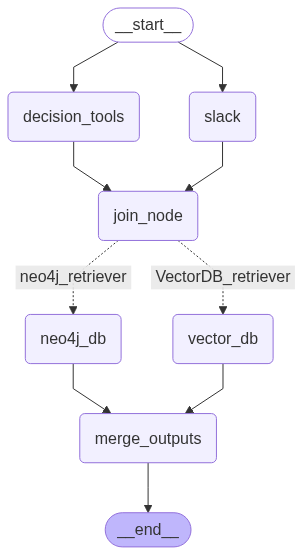

In [6]:
builder = StateGraph(ChatbotState)

builder.add_node("slack", decision_slack)
builder.add_node("decision_tools", decision_tools)
builder.add_node("join_node", join_node)
builder.add_node("vector_db", vector_db)
builder.add_node("neo4j_db", neo4j_db)
builder.add_node("merge_outputs", merge_outputs)

builder.add_edge(START, "decision_tools")
builder.add_edge(START, "slack")

builder.add_edge("slack", "join_node")
builder.add_edge("decision_tools", "join_node")

def route_tools(state: ChatbotState):
    return state["tools"]

# builder.add_conditional_edges(
#     "decision_tools",
#     route_tools,
#     {
#         "neo4j_retriever": "neo4j_db",
#         "VectorDB_retriever": "vector_db"
#     }
# )

builder.add_conditional_edges(
    "join_node",
    route_tools,
    {
        "neo4j_retriever": "neo4j_db",
        "VectorDB_retriever": "vector_db"
    }
)

builder.add_edge("neo4j_db", "merge_outputs")
builder.add_edge("vector_db", "merge_outputs")
builder.add_edge("merge_outputs", END)

builder.compile(checkpointer=memory)

In [7]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

question = "Kasabach-Merrritt Syndrome에 대해서 조사하고 slack으로 전달해줘."

graph = builder.compile(checkpointer=memory)

initial_state = {
    "question": question,
    "decision_slack":"",
    "tools": [],
    "tools_query" : [],
    "neo4j_documents": [],
    "vector_documents": [],
    "final_answer": "",
    "slack_response":"",
    "messages": [],
}

events = []
async for event in graph.astream(initial_state, config=config):
    print(event)


{'decision_tools': {'tools': ['VectorDB_retriever'], 'tools_query': ['Kasabach-Merritt Syndrome 설명, 원인, 진단, 증상, 치료 방법, 예후']}}
{'slack': {'decision_slack': 'Yes'}}
{'join_node': {'question': 'Kasabach-Merrritt Syndrome에 대해서 조사하고 slack으로 전달해줘.', 'decision_slack': 'Yes', 'tools': ['VectorDB_retriever'], 'tools_query': ['Kasabach-Merritt Syndrome 설명, 원인, 진단, 증상, 치료 방법, 예후'], 'neo4j_documents': [], 'vector_documents': [], 'final_answer': '', 'slack_response': '', 'messages': []}}
{'vector_db': {'vector_documents': 'Laparoscopic cholecystectomy for symptomatic cholecystolithiasis (CCL) in "Kasabach-Merritt syndrome" (KMS) (Kaposi-tumor like hemangioendothelioma with case-specific perioperative management).\n\nOBJECTIVES: The Kasabach-Merritt syndrome (KMS) is characterized by the occurrence of hemangioendothelioma (giant hemangioma with thrombosis leading to thrombocytopenia), which can be associated with disseminated intravasal coagulation. Specific aim: Based on (i) selective references fr